# Univariate Time Series ConvLSTM Model for [PROJECT NAME] Using TensorFlow Version 1
### David Lowe
### February 9, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

Additional Notes: The workflow is a replication of Dr. Brownlee's blog post "Deep Learning Models for Univariate Time Series Forecasting" (https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/). I plan to build a script for building future projects by adapting the example workflow presented in the blog.

SUMMARY: [Sample Paragraph - The project aims to construct a time series prediction model and document the end-to-end steps using a template. The [PROJECT NAME] dataset is an univariate time series situation where we are trying to forecast future outcomes based on past data points.]

INTRODUCTION: [Sample Paragraph - The problem is to forecast the monthly number of airline passenger miles traveled in the United States. The dataset describes a time-series of miles (in millions) over 18 years (1960-1977), and there are 216 observations. We used the first 80% of the observations for training various models while holding back the remaining observations for validating the final model.]

ANALYSIS: [Sample Paragraph - The baseline persistence model yielded an RMSE of 2.278. The CNN model processed the same test data with an RMSE of 1.674, which was better than the baseline model as expected.]

CONCLUSION: For this dataset, the chosen TensorFlow ConvLSTM model achieved a satisfactory result and should be considered for further modeling.

Dataset Used: [Sample Paragraph - Monthly U.S Air Passenger Miles January 1960 through December 1977]

Dataset ML Model: Time series forecast with numerical attribute

Dataset Reference: Rob Hyndman and Yangzhuoran Yang (2018). tsdl: Time Series Data Library. v0.1.0. https://pkg.yangzhuoranyang./tsdl/.

## Task 1 - Define Problem and Acquire Data

In [1]:
# # Retrieve the GPU information
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [2]:
# # Retrieve memory configuration information
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


In [4]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

### 1.a) Load Libraries

In [5]:
# Create the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn.metrics import mean_squared_error

import tensorflow as tf
tf.random.set_seed(RNG_SEED)

2022-01-17 03:36:43.234857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-17 03:36:43.234935: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set various default modeling parameters
DEFAULT_LOSS = 'mean_squared_error'
DEFAULT_METRICS = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
MAX_EPOCHS = 20
BATCH_SIZE = 16
SLIDING_WINDOW = 5

2022-01-17 03:36:47.658808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-17 03:36:47.658885: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-17 03:36:47.658936: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (32eee83f52a0): /proc/driver/nvidia/version does not exist


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 1 - Define Problem and Acquire Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

In [10]:
# load the dataset and the necessary data structure
time_series = pd.read_csv('https://dainesanalytics.com/datasets/time-series-data-library/tsdl200.csv', index_col='idx', parse_dates=True)

# Load the dataset from the Federal Reserve Bank's FRED Database
# starting = datetime(1990, 1, 1)
# ending = datetime.now()
# fred_data = 'SMU06000007072251101'
# time_series = web.DataReader(fred_data, 'fred', starting, ending)
# time_series.rename(columns={fred_data: 'value'}, inplace=True)

# Sample code for subsetting the time-series data
# time_series = original_series['1986':'1990']

In [11]:
target_col = time_series.columns[0]
lower_bound = 'lower ' + target_col
upper_bound = 'upper ' + target_col
print('The target column of the time series is:', target_col)
print('The forecast boundary columns are:', lower_bound, '&', upper_bound)

The target column of the time series is: values
The forecast boundary columns are: lower values & upper values


In [12]:
time_series.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 1960-01-01 to 1977-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   values  216 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


In [13]:
print(time_series.head())

            values
idx               
1960-01-01    2.42
1960-02-01    2.14
1960-03-01    2.28
1960-04-01    2.50
1960-05-01    2.44


In [14]:
print(time_series.tail())

            values
idx               
1977-08-01   19.49
1977-09-01   15.61
1977-10-01   16.16
1977-11-01   14.84
1977-12-01   17.04


In [15]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 1 - Define Problem and Acquire Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2: Summarize and Visualize Data

In [16]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

In [17]:
# Summary statistics of time series
print(time_series.describe())

           values
count  216.000000
mean     8.327546
std      4.924629
min      1.820000
25%      3.505000
50%      7.100000
75%     12.902500
max     19.490000


### 2.b) Line Plot of the Time Series Data

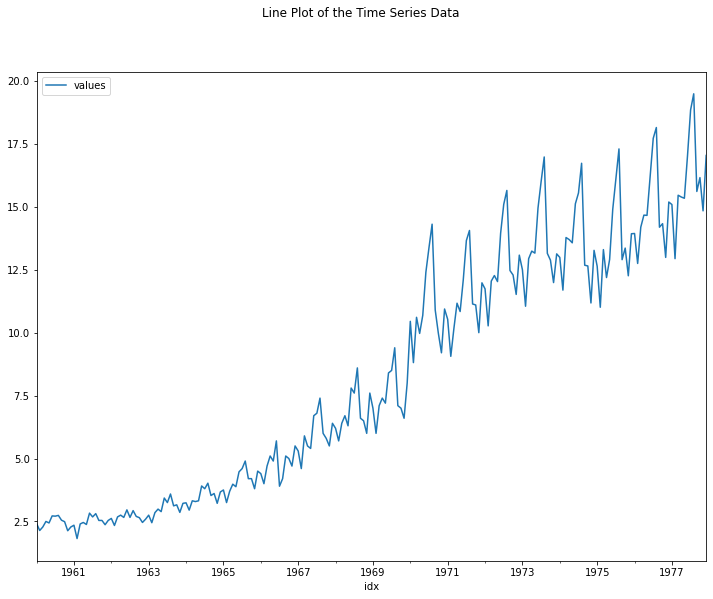

In [18]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Time Series Data')
time_series.plot(ax=ax)
plt.show()

### 2.c) Histogram and Density Plots of the Time Series Data

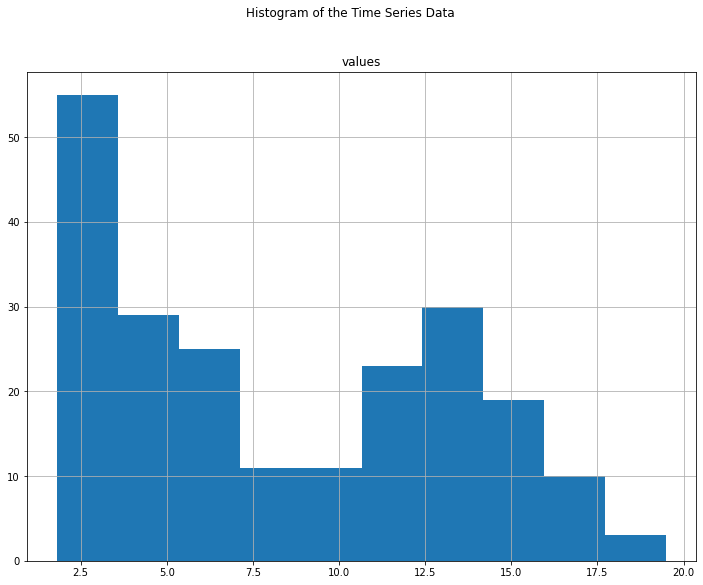

In [19]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Histogram of the Time Series Data')
time_series.hist(ax=ax)
plt.show()

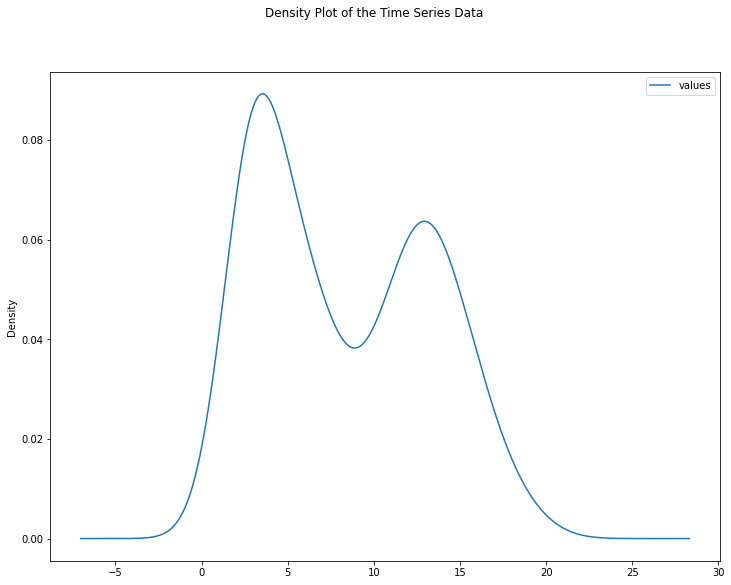

In [20]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Density Plot of the Time Series Data')
time_series.plot(kind='kde', ax=ax)
plt.show()

### 2.d) Box and Whisker Plots of the Time Series Data

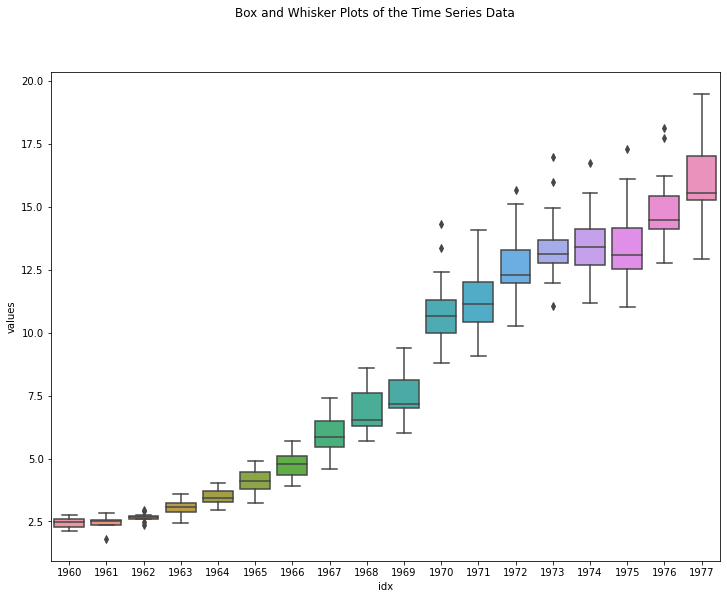

In [21]:
# boxplots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Box and Whisker Plots of the Time Series Data')
squeezed = time_series.squeeze()
sns.boxplot(x=squeezed.index.year, y=squeezed, ax=ax)
plt.show()

In [22]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3: Pre-Process Data

In [23]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 3 - Pre-Process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [24]:
# Resampling the time series into monthly average for the ease of modeling
# original_series = time_series
# resample = original_series.resample('M')
# time_series = resample.mean()
# time_series.head(10)

In [25]:
# Split the data into training and test sets
data = time_series.values
data = data.astype('float32')
n_test = 12
n_train = len(data) - n_test
train_ts, test_ts = data[0:n_train], data[n_train:]
print('Number of data points in the training set:', n_train)
print('Number of data points in the test set:', n_test)

Number of data points in the training set: 204
Number of data points in the test set: 12


In [26]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 3 - Pre-Process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4: Train and Tune Models

In [27]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set up the Common Helper Functions

In [28]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    plt.boxplot(scores)
    plt.show()

### 4.b) Simple Persistent Modeling as a Baseline

In [29]:
# fit a model
def model_fit(train, config):
    return None

In [30]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    values = list()
    for offset in config:
        values.append(history[-offset])
    return np.median(values)

In [31]:
# define config
config = [12, 24, 36]
# grid search
scores = repeat_evaluate(data, config, n_test)

 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278
 > 2.278


Persistence Model:: 2.278 RMSE (+/- 0.000)


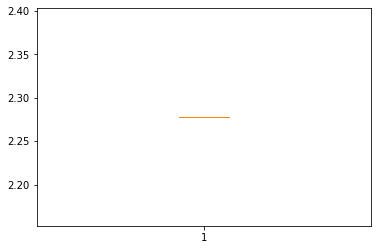

In [32]:
# summarize scores
summarize_scores('Persistence Model:', scores)

### 4.c) ConvLSTM Modeling and Tuning

In [33]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel), activation='relu', input_shape=(n_seq, 1, n_steps, 1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_nodes, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss=DEFAULT_LOSS, optimizer=DEFAULT_OPTIMIZER)
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [34]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = np.array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [35]:
# define config
config = [3, 12, 256, 3, 200, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)

 > 1.164
 > 1.065
 > 1.320
 > 2.436
 > 1.356
 > 2.013
 > 1.334
 > 1.622
 > 1.921
 > 1.678
 > 1.163
 > 1.683
 > 1.689
 > 1.250
 > 1.377
 > 2.719
 > 1.864
 > 2.127
 > 0.966
 > 2.386
 > 1.976
 > 2.220
 > 0.835
 > 1.172
 > 1.747
 > 1.936
 > 1.297
 > 1.649
 > 1.820
 > 2.454


ConvLSTM Model:: 1.674 RMSE (+/- 0.476)


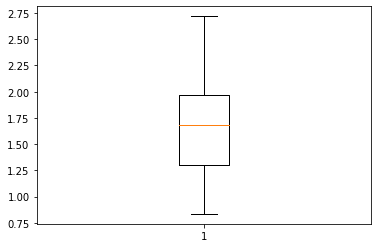

In [36]:
# summarize scores
summarize_scores('ConvLSTM Model:', scores)

In [37]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize Model and Make Predictions

In [38]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [39]:
# Code Segment Under Construction

In [40]:
if NOTIFY_STATUS: status_notify("TensorFlow Time Series Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [41]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:44:25.059307
